In [1]:
%matplotlib inline

from IPython import display
import matplotlib.pyplot as plt
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import transforms, utils
import glob
import pickle
import time
import numpy as np

# Generative Adversarial Networks (GANs)


The following code heavily borrows from the nice introduction available at: https://github.com/diegoalejogm/gans/blob/master/1.%20Vanilla%20GAN%20PyTorch.ipynb

## Face dataset as class
Let's first define a class for the faces that we would like to learn from. We will derive this class from the PyTorch class `Dataset`, and will need to overload the constructor `__init__` and the indexing operator `__getitem__`. For convenience, we also define the length of the dataset and a function that shows a picture of the loaded data.

The dataset is already pickled and consists of >13000 cropped faces from the Labelled-Faces-In-The-Wild (LFW) dataset. 

In [2]:
class faceDataset(Dataset):
    """Face dataset."""
    def __init__(self, pickle_file, normalize=0):
        """
        Args:
            pickle_file (string): full path to pickled face data from LFW.
            normalize (callable, optional): Optional normalization of images
        """
        self.pickle_file = pickle_file
        self.normalize = normalize
        with open(self.pickle_file, 'rb') as fo:
            tmp = pickle.load(fo,encoding='bytes')
            tmp = tmp.reshape((tmp.shape[0],1,32,32))
            self.images = torch.from_numpy(tmp)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        sample=self.images[idx,:]

        if self.normalize==1:
            sample = (sample)/sample.max()
        return sample
    def show(self,idx):
        plt.figure()
        plt.imshow(self.images[idx,0,:].numpy().squeeze(),cmap='gray')

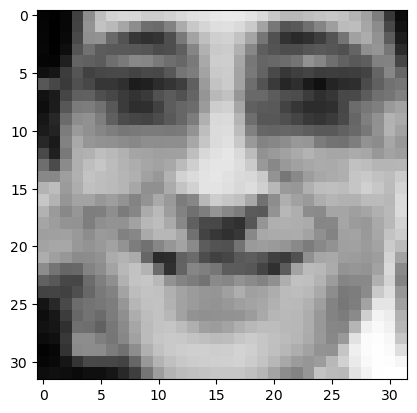

In [3]:
face_dataset = faceDataset(pickle_file='faces_python.pkl',normalize=0)
face_dataset.show(100)

In order to make training more comfortable, we can use PyTorch's own `DataLoader` class, which takes a dataset and returns batches from it in an iterator. 

In [4]:
dataloader = DataLoader(face_dataset, batch_size=100,
                        shuffle=True, num_workers=0)
num_batches = len(dataloader)
print('face dataset has',len(face_dataset),'faces and',num_batches,'batches')

face dataset has 13233 faces and 133 batches


In [ ]:
# sampling from dataloader and converting it to NCHW format
face_sample = next(iter(dataloader)).reshape(100,1,32,32)
face_grid = utils.make_grid(face_sample, nrow=10).numpy()

# Converting torch CHW format to matplotlib HWC format
face_grid = np.moveaxis(face_grid, 0, -1)

fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.imshow(face_grid, cmap='gray')
ax.axis('off')

## Discriminator

We first define the discriminator, which is supposed to detect whether an image is fake or not.

It is derived from PyTorch's `nn.Module` and needs to provide the constructor `__init__` in which we set up the network layers and the `forward` function, which defines how to pass information from one layer to the next.

Instead of our simple, fully-connected, three-layer network from before, we now use a convolutional architecture with increasing filter size, which we know works well with images.

The activation function is set to a leaky ReLU, which improves stability a bit. Instead of dropout we use batch normalization, which is known to improve generalization for CNNs.

Instead of a fully-connnected layer, the last layer in the discriminator is implemented as a 1D convolution.

In [5]:
class DiscriminatorNet(torch.nn.Module):
    """
    A four-layer discriminative CNN
    """
    def __init__(self):
        super().__init__()
        # three convolutional layers
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=32, kernel_size=4, 
                stride=2, padding=1, bias=False
            ),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=32, out_channels=64, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=64, out_channels=128, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.out = nn.Sequential(
            nn.Conv2d(in_channels=128*4*4, out_channels=1, kernel_size=1, stride=1, padding=0, bias=False),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # Convolutional layers
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        # Flatten and apply sigmoid
        x = x.view(-1, 128*4*4, 1, 1)
        x = self.out(x)
        return x
    # reset weights
    def reset(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.reset_parameters()
                m.weight.data.normal_(0.00, 0.02)

We next define a helper function for visualization.

In [6]:
def numpy_to_plotly(arr):
    tmp = (arr-arr.min())/(arr.max()-arr.min())*255
    return np.dstack((tmp,tmp,tmp))

## Generator

This class defines the generator, which takes noise as input and then generates a 32x32 pixel image from this.

Note that in order to do this, we have to use Transposed Convolution, which takes a filter so as to upsample an input image.

To keep the discriminator and generator symmetric, we use the same amount of filters when upsampling, as when downsampling in the discriminator.

In addition, the generator also uses a 1D upsampling step, which generates an image-like filter input to the next layer.

In [7]:
class GeneratorNet(torch.nn.Module):
    """
    A four-layer generative CNN
    """
    def __init__(self):
        super().__init__()
        
        # this first layer converts the hidden layer to the initial 
        # image-like filter representation via 1D convolution
        self.conv0 = nn.ConvTranspose2d(in_channels=100, out_channels=128*4*4, kernel_size=1, stride=1, padding=0, bias=False)
        
        # now upsample three times
        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=128, out_channels=64, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=64, out_channels=32, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=32, out_channels=1, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
        )
        self.out = torch.nn.Tanh()

    def forward(self, x):
        # Project and reshape
        x = x.view(x.shape[0], 100, 1, 1)
        
        # Convolutional layers
        x = self.conv0(x)
        x = x.view(x.shape[0], 128, 4, 4)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        # Apply Tanh
        return self.out(x)
    # reset weights
    def reset(self):
        for m in self.modules():
            if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
                m.reset_parameters()
                m.weight.data.normal_(0.00, 0.02)

In order to create the noise distribution from which the generator is supposed to work, we create a helper function:

In [8]:
# Noise
def noise(size):
    n = torch.randn(size, 100)
    if torch.cuda.is_available(): return n.cuda() 
    return n

## Training the GAN

First we instantiate the two networks, and push them to CUDA, if possible.

In [9]:
discriminator = DiscriminatorNet()
generator = GeneratorNet()

#from modelsummary import summary
#summary(discriminator, torch.zeros((1, 1, 32, 32)), show_input=True)
#summary(discriminator, torch.zeros((1, 1, 32, 32)), show_input=False)

#summary(generator, torch.zeros((1,100,1,1)), show_input=True)
#summary(generator, torch.zeros((1,1,100)), show_input=False)


In [10]:
if torch.cuda.is_available():
    discriminator.cuda()
    generator.cuda()

Next, we set up the networks' optimizing schemes. As usual, we take Adam, but with a rather low learning rate.

In [11]:
# Optimizers
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [12]:
# Loss function
loss = nn.BCELoss()


Now we will define two helper functions that create targets for real data ($y_n=1$) and fake data ($y_n=0$) for us.

In [13]:
def real_data_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = torch.ones(size, 1, 1, 1)
    if torch.cuda.is_available(): return data.cuda()
    return data

def fake_data_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = torch.zeros(size, 1, 1, 1)
    if torch.cuda.is_available(): return data.cuda()
    return data

Here comes the real beef of the training. 

The `train_discriminator` function takes the real and fake labels and the optimizer and then first trains the discriminator on the real data, and then on the fake data, returning the total error of the two steps.

The `train_generator` function does the same by taking the error of the discriminator for predicting fake data and pretending that to be real.

In [14]:
def train_discriminator(optimizer, real_data, fake_data):
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    # Error is measured against real data targets
    error_real = loss(prediction_real, real_data_target(real_data.size(0)))
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    # Error is measured against fake targets
    error_fake = loss(prediction_fake, fake_data_target(real_data.size(0)))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error
    return error_real + error_fake, prediction_real, prediction_fake

def train_generator(optimizer, fake_data):
    # 2. Train Generator
    # Reset gradients
    optimizer.zero_grad()
    # Sample noise and generate fake data
    prediction = discriminator(fake_data)
    # Calculate error and backpropagate
    # Note that here the error is pretending to be real
    error = loss(prediction, real_data_target(prediction.size(0)))
    error.backward()
    # Update weights with gradients
    optimizer.step()
    # Return error
    return error

The core of the generator is the noise from which the images are supposed to be generated. Let's see what that looks like initially.

Text(0, 0.5, 'number')

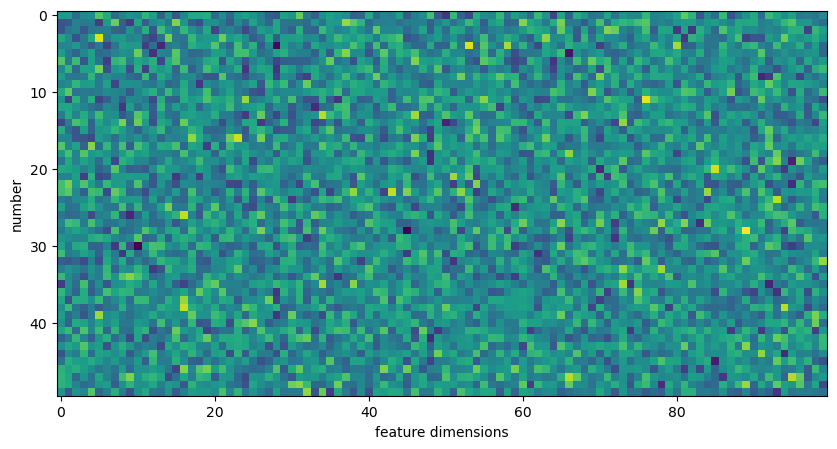

In [15]:
num_test_samples = 50
test_noise = noise(num_test_samples)
fig, ax = plt.subplots(1, 1, figsize=(10,5))
ax.imshow(test_noise.cpu())
ax.set_xlabel('feature dimensions')
ax.set_ylabel('number')

In [16]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from ipywidgets import interact
fig = make_subplots(rows=4, cols=4)

for i in range(4):
    for j in range(4):
        fig.append_trace(go.Image(z=np.zeros((32,32,3))),row=i+1,col=j+1)
fig = go.FigureWidget(fig)
fig.update_xaxes(showticklabels=False)
fig.update_yaxes(showticklabels=False)
fig.update_layout(
    autosize=False,
    width=800,
    height=800,
)
fig

FigureWidget({
    'data': [{'type': 'image',
              'uid': '3935ad15-4f7c-48af-99b2-4f5123159820',
              'xaxis': 'x',
              'yaxis': 'y',
              'z': array([[[0., 0., 0.],
                           [0., 0., 0.],
                           [0., 0., 0.],
                           ...,
                           [0., 0., 0.],
                           [0., 0., 0.],
                           [0., 0., 0.]],
                   
                          [[0., 0., 0.],
                           [0., 0., 0.],
                           [0., 0., 0.],
                           ...,
                           [0., 0., 0.],
                           [0., 0., 0.],
                           [0., 0., 0.]],
                   
                          [[0., 0., 0.],
                           [0., 0., 0.],
                           [0., 0., 0.],
                           ...,
                           [0., 0., 0.],
                           [0., 0., 0.],
  

In [17]:
dataloader = DataLoader(face_dataset, batch_size=100,
                        shuffle=True, num_workers=0)

discriminator.reset()
generator.reset()

# Number of epochs for training the GAN
num_epochs = 50

t_start = time.time()
duration_avg = 0.0

for epoch in range(num_epochs):
    for n_batch, real_data in enumerate(dataloader):
        # 1. Train Discriminator with real images
        if torch.cuda.is_available(): real_data = real_data.cuda()
        # Generate fake data from noise, do not update
        # gradients here - hence add ".detach()"
        noi = noise(real_data.size(0))
        fake_data = generator(noi).detach()
        # Train discriminator with the real and fake data
        d_error, d_pred_real, d_pred_fake = \
                            train_discriminator(d_optimizer,                                    
                            real_data.float(), fake_data)

        # 2. Train Generator
        # Generate fake data from noise
        fake_data = generator(noi)#noise(real_batch.size(0)))
        # Train G
        g_error = train_generator(g_optimizer, fake_data)
        # Display Progress
        if (n_batch) % 50 == 0:
            test_images = generator(test_noise).data.cpu()
            p=0
            with fig.batch_update():
                for i in range(4):
                    for j in range(4):
                        tmp=test_images[p,0,:,:].numpy()
                        fig.data[p]['z']=numpy_to_plotly(tmp)
                        p+=1
            fig.update_layout(
                title={
                    'text':'epoch {0:} batch {1:} L(D)={2: .3f} L(G)={3: .3f} t={4: .1f}s/it'.format(
                        epoch,n_batch,d_error,g_error,duration_avg),
                    'xanchor':'center',
                    'x':0.5
                })
                
    t_end = time.time()
    duration_avg = (t_end - t_start) / (epoch + 1.0)

KeyboardInterrupt: 

As we can see for a lower number of parameters, this network produces well-represented faces.